In [149]:
import warnings
warnings.filterwarnings('ignore')

## Data Preperation

In [150]:
# Importing necessary libraries and importing CSV files into respective dataframes

import pandas as pd

df_CPI = pd.read_csv("./data/housing-affordability-in-canada/CPI-inflation-by-region-1914-202.csv")
df_Housing = pd.read_csv("./data/housing-affordability-in-canada/housing-supply-price-rental.csv")
df_HPIRegions = pd.read_csv("./data/housing-affordability-in-canada/HPI 1981-2022 by regions.csv")
df_HPIFederalandProvincial = pd.read_csv("./data/housing-affordability-in-canada/HPI 1981-2022 federal and provincial.csv")
df_Income = pd.read_csv("./data/housing-affordability-in-canada/income-distribution-2012-2020.csv")
df_Interest = pd.read_csv("./data/housing-affordability-in-canada/Interest and mortgage rates 1951-2022.csv")
df_PopulationDwellings = pd.read_csv("./data/housing-affordability-in-canada/population_dwellings_count.csv")
df_PopulationRegion = pd.read_csv("./data/housing-affordability-in-canada/population-by-region-1946-2022.csv")
df_Structural = pd.read_csv("./data/housing-affordability-in-canada/Structural-dwellings-household-size.csv")
df_CPI['GEO'].unique()


array(['Canada', "St. John's, Newfoundland and Labrador",
       'Halifax, Nova Scotia', 'Saint John, New Brunswick',
       'Québec, Quebec', 'Montréal, Quebec',
       'Ottawa-Gatineau, Ontario part, Ontario/Quebec',
       'Toronto, Ontario', 'Thunder Bay, Ontario', 'Winnipeg, Manitoba',
       'Regina, Saskatchewan', 'Saskatoon, Saskatchewan',
       'Edmonton, Alberta', 'Calgary, Alberta',
       'Vancouver, British Columbia',
       'Charlottetown and Summerside, Prince Edward Island',
       'Newfoundland and Labrador', 'Prince Edward Island', 'Nova Scotia',
       'New Brunswick', 'Quebec', 'Ontario', 'Manitoba', 'Saskatchewan',
       'Alberta', 'British Columbia', 'Whitehorse, Yukon',
       'Yellowknife, Northwest Territories', 'Victoria, British Columbia',
       'Iqaluit, Nunavut'], dtype=object)

In [151]:
# Removes region rows that aren't Canada and selects "All-items"
# df_CPI = df_CPI[df_CPI['GEO'] == 'Canada']
# df_CPI.drop(columns=['GEO'], inplace=True)

provinces = ['Prince Edward Island', 'Nova Scotia', 'New Brunswick', 'Quebec', 'Ontario', 'Manitoba', 'Saskatchewan', 'Alberta']

df_CPI = df_CPI[df_CPI['GEO'].isin(provinces)]


df_CPI = df_CPI[df_CPI['Products and product groups'] == 'All-items']
df_CPI.drop(columns=['Products and product groups'], inplace=True)

# Removes unnecessary columns
df_CPI.drop(columns=['DGUID'], inplace=True)
df_CPI.drop(columns=['UOM'], inplace=True)
df_CPI.drop(columns=['UOM_ID'], inplace=True)
df_CPI.drop(columns=['VECTOR'], inplace=True)
df_CPI.drop(columns=['COORDINATE'], inplace=True)

# Standardizes "Date" name and format
df_CPI['Date'] = df_CPI['REF_DATE'].astype(str) + '01'
df_CPI.drop(columns=['REF_DATE'], inplace=True)

# df_CPI.head(108)

In [152]:
# Standardizes "Date" format and name
df_Housing['Date'] = df_Housing['year'].astype(str).str.replace('.0', '').str.replace('.1', '') + '01'

df_Housing = df_Housing[['Date', 'region', 'population', 'total_dwelling', 'total_dwelling_market', 'labour_participation_rate', 'unemployment_rate', 'disposable_income_change', 
                         'rental_vacancy_rate', 'rental_avilability_rate', 'owned_accommodation_costs_change', 'rental_accommodation_costs_change']]

regions_to_include = ['manitoba', 'prince_edward', 'new_brunswick', 'saskatchewan', 'nova_scotia', 'quebec', 'alberta', 'ontario']

df_Housing = df_Housing[df_Housing['region'].isin(regions_to_include)]

province_mapping = {
    'manitoba': 'Manitoba',
    'prince_edward': 'Prince Edward Island',
    'new_brunswick': 'New Brunswick',
    'saskatchewan': 'Saskatchewan',
    'nova_scotia': 'Nova Scotia',
    'quebec': 'Quebec',
    'alberta': 'Alberta',
    'ontario': 'Ontario'
}

# Update province names in the DataFrame
df_Housing['region'] = df_Housing['region'].map(province_mapping)

df_Housing.shape

(216, 12)

In [153]:

df_HPIRegions = df_HPIRegions[df_HPIRegions['Type'] == 'House and Land']
df_HPIRegions.drop(columns = ['Type'], inplace=True)

# List of columns representing regions
regions_columns = ['Prince Edward Island', 'Nova Scotia', 'New Brunswick', 'Quebec', 'Ontario', 'Manitoba', 'Saskatchewan', 'Alberta']

# Melt the dataframe to transform the columns into a single 'region' column
df_HPIRegions = df_HPIRegions.melt(id_vars=['Month-year'], value_vars=regions_columns, var_name='region', value_name='value')
df_HPIRegions = df_HPIRegions.dropna()
df_HPIRegions.head(20)



# Converts "Month-year" to standard format and renames column to "Date"
df_HPIRegions['Month-year'] = pd.to_datetime(df_HPIRegions['Month-year'], format='%b-%y')
def adjust_year(date):
    
    if date.year - 2000 >= 25 and date.year - 2000 <= 99:
        return date.replace(year=date.year - 100)

    return date
df_HPIRegions['Month-year'] = df_HPIRegions['Month-year'].apply(adjust_year)
df_HPIRegions['Month-year'] = df_HPIRegions['Month-year'].dt.strftime('%Y%m')
df_HPIRegions.rename(columns={'Month-year': 'Date'}, inplace=True)
# df_HPIRegions.rename(columns={'Month-year': 'Date'}, inplace=True)

df_HPIRegions.head(1494)

,Date,region,value
60,198601,Prince Edward Island,83.5
61,198602,Prince Edward Island,83.5
62,198603,Prince Edward Island,83.5
63,198604,Prince Edward Island,83.5
64,198605,Prince Edward Island,83.5
...,...,...,...
1729,200008,Quebec,58.3
1730,200009,Quebec,58.6
1731,200010,Quebec,58.8
1732,200011,Quebec,59.0


In [154]:
df_Housing.shape

(216, 12)

In [155]:
merged_df = pd.merge(df_Housing, df_HPIRegions, left_on=['Date', 'region'], right_on=['Date', 'region'], how='left')
merged_df = pd.merge(merged_df, df_CPI, left_on=['Date', 'region'], right_on=['Date', 'GEO'])
merged_df = merged_df.dropna()
merged_df.drop(columns=['GEO'], inplace=True)
merged_df.rename(columns={'value': 'HPI'}, inplace=True)

# Calculate the number of months passed
merged_df['Date'] = pd.to_datetime(merged_df['Date'], format='%Y%m')
# merged_df['Num of Months Passed'] = (merged_df['Date'] - merged_df['Date'].min()) // pd.Timedelta(days=30)
merged_df['year'] = merged_df['Date'].dt.year

merged_df.shape

(64, 15)

In [156]:
provinces = pd.get_dummies(merged_df['region'], prefix='region')
provinces = provinces.astype(int)
merged_df = merged_df.join(provinces)
merged_df = merged_df.drop(['region'], axis=1) 
merged_df.head()

,Date,population,total_dwelling,total_dwelling_market,labour_participation_rate,unemployment_rate,disposable_income_change,rental_vacancy_rate,rental_avilability_rate,owned_accommodation_costs_change,...,CPI,year,region_Alberta,region_Manitoba,region_New Brunswick,region_Nova Scotia,region_Ontario,region_Prince Edward Island,region_Quebec,region_Saskatchewan
0,1992-01-01,1112.689,2310,1821,66.475000,9.3,-0.326989,5.8,2.7,0.359644,...,81.2,1992,0,1,0,0,0,0,0,0
1,1993-01-01,1117.618,2425,1702,66.850000,9.3,-0.453243,5.6,2.7,-0.028291,...,83.4,1993,0,1,0,0,0,0,0,0
2,1994-01-01,1123.230,3197,1664,66.750000,8.8,0.161821,5.5,2.7,1.480992,...,84.6,1994,0,1,0,0,0,0,0,0
3,1995-01-01,1129.150,1963,1215,66.575000,7.3,-0.326547,5.2,2.7,3.402119,...,86.9,1995,0,1,0,0,0,0,0,0
4,1996-01-01,1134.196,2318,1243,66.441667,7.2,-0.052561,5.6,2.7,0.647249,...,88.8,1996,0,1,0,0,0,0,0,0


In [157]:
merged_df.head()

,Date,population,total_dwelling,total_dwelling_market,labour_participation_rate,unemployment_rate,disposable_income_change,rental_vacancy_rate,rental_avilability_rate,owned_accommodation_costs_change,...,CPI,year,region_Alberta,region_Manitoba,region_New Brunswick,region_Nova Scotia,region_Ontario,region_Prince Edward Island,region_Quebec,region_Saskatchewan
0,1992-01-01,1112.689,2310,1821,66.475000,9.3,-0.326989,5.8,2.7,0.359644,...,81.2,1992,0,1,0,0,0,0,0,0
1,1993-01-01,1117.618,2425,1702,66.850000,9.3,-0.453243,5.6,2.7,-0.028291,...,83.4,1993,0,1,0,0,0,0,0,0
2,1994-01-01,1123.230,3197,1664,66.750000,8.8,0.161821,5.5,2.7,1.480992,...,84.6,1994,0,1,0,0,0,0,0,0
3,1995-01-01,1129.150,1963,1215,66.575000,7.3,-0.326547,5.2,2.7,3.402119,...,86.9,1995,0,1,0,0,0,0,0,0
4,1996-01-01,1134.196,2318,1243,66.441667,7.2,-0.052561,5.6,2.7,0.647249,...,88.8,1996,0,1,0,0,0,0,0,0


In [158]:
merged_df.describe()

,population,total_dwelling,total_dwelling_market,labour_participation_rate,unemployment_rate,disposable_income_change,rental_vacancy_rate,rental_avilability_rate,owned_accommodation_costs_change,rental_accommodation_costs_change,...,CPI,year,region_Alberta,region_Manitoba,region_New Brunswick,region_Nova Scotia,region_Ontario,region_Prince Edward Island,region_Quebec,region_Saskatchewan
count,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,...,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000
mean,3122.909062,13824.890625,11464.796875,64.845964,10.228125,1.568465,4.923438,4.887500,0.549796,1.358883,...,87.617188,1995.500000,0.125000,0.125000,0.125000,0.125000,0.125000,0.125000,0.125000,0.125000
std,3692.110190,17275.739769,15498.241573,3.963626,3.170372,1.986774,1.927392,1.631778,1.223803,0.609941,...,3.296297,2.309401,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333
min,130.827000,422.000000,245.000000,58.400000,5.500000,-3.918201,1.400000,2.400000,-1.572577,0.343968,...,80.600000,1992.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,877.716000,2398.250000,1614.000000,61.641667,7.275000,0.210657,2.950000,3.825000,-0.411631,0.912783,...,84.950000,1993.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1065.817000,3501.500000,2181.500000,65.650000,9.900000,1.323429,5.300000,5.050000,0.377669,1.270379,...,87.950000,1995.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3992.021500,23332.750000,18491.750000,66.583333,12.525000,3.480862,6.375000,6.400000,1.567646,1.732808,...,90.425000,1997.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,11504.759000,67235.000000,62925.000000,72.616667,17.600000,5.771596,8.600000,6.900000,3.402119,2.917392,...,93.600000,1999.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [159]:
import seaborn as sns
import matplotlib.pyplot as plt

In [160]:
merged_df[['Date', 'population', 'total_dwelling', 'total_dwelling_market',
       'labour_participation_rate', 'unemployment_rate',
       'disposable_income_change', 'rental_vacancy_rate',
       'rental_avilability_rate', 'owned_accommodation_costs_change',
       'rental_accommodation_costs_change', 'HPI', 'CPI', 'year']]

,Date,population,total_dwelling,total_dwelling_market,labour_participation_rate,unemployment_rate,disposable_income_change,rental_vacancy_rate,rental_avilability_rate,owned_accommodation_costs_change,rental_accommodation_costs_change,HPI,CPI,year
0,1992-01-01,1112.689,2310,1821,66.475000,9.3,-0.326989,5.8,2.7,0.359644,2.844702,38.3,81.2,1992
1,1993-01-01,1117.618,2425,1702,66.850000,9.3,-0.453243,5.6,2.7,-0.028291,1.731113,39.2,83.4,1993
2,1994-01-01,1123.230,3197,1664,66.750000,8.8,0.161821,5.5,2.7,1.480992,0.906316,40.7,84.6,1994
3,1995-01-01,1129.150,1963,1215,66.575000,7.3,-0.326547,5.2,2.7,3.402119,1.173128,41.9,86.9,1995
4,1996-01-01,1134.196,2318,1243,66.441667,7.2,-0.052561,5.6,2.7,0.647249,0.914938,42.2,88.8,1996
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,1995-01-01,10950.119,35818,31893,65.475000,8.7,1.149276,2.3,5.7,1.460726,1.737892,53.6,86.8,1995
60,1996-01-01,11082.903,43062,39512,65.541667,9.0,0.055310,3.0,5.7,-0.833032,1.437506,53.3,88.2,1996
61,1997-01-01,11227.651,54072,49972,65.733333,8.4,3.625058,2.8,5.7,-0.776114,1.490752,53.3,89.8,1997
62,1998-01-01,11365.901,53830,50088,65.933333,7.2,4.683412,2.6,5.7,0.395693,1.260314,54.8,90.6,1998


In [161]:
ax = sns.pairplot(data=merged_df, vars=['Date', 'population', 'total_dwelling', 'total_dwelling_market',
       'labour_participation_rate', 'unemployment_rate',
       'disposable_income_change', 'rental_vacancy_rate',
       'rental_avilability_rate', 'owned_accommodation_costs_change',
       'rental_accommodation_costs_change', 'HPI', 'CPI', 'year'])
plt.savefig("pair_plot.png")
ax

## Model and Feature Selection

### Base model

In [162]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt


y= merged_df['HPI']
X = merged_df.drop(['HPI', 'Date'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20, stratify=merged_df['year'], random_state=156)

model_linear = LinearRegression()

model_linear.fit(X_train, y_train)

y_pred = model_linear.predict(X_test)

mse_linear = metrics.mean_squared_error(y_test, y_pred)
rmse_linear = metrics.mean_squared_error(y_test, y_pred, squared=False)
r2_linear = metrics.r2_score(y_test, y_pred)

print("Coefficients:")
for feature, coef in zip(X.columns, model_linear.coef_):
    print(feature, ":", coef)
print("")
print("Mean Squared Error (MSE):", mse_linear)
print("Root Mean Squared Error (RMSE):", rmse_linear)
print("R-squared (R2):", r2_linear)


Coefficients:
population : -0.001519321262265218
total_dwelling : 0.0004937164848385837
total_dwelling_market : -0.0004307797880821022
labour_participation_rate : -2.18679523291429
unemployment_rate : 0.5173174135526823
disposable_income_change : -0.08786741131555272
rental_vacancy_rate : -0.09139574300965558
rental_avilability_rate : 4.1755349343051
owned_accommodation_costs_change : 0.5126275733567779
rental_accommodation_costs_change : 0.4273030998125023
CPI : 0.807519708280845
year : -0.23394292993197613
region_Alberta : 2.8908528110388914
region_Manitoba : -2.139525409061027
region_New Brunswick : 4.060709271861605
region_Nova Scotia : -7.726388548153211
region_Ontario : 6.151721946541003
region_Prince Edward Island : 14.28311342049561
region_Quebec : 4.4481024026873035
region_Saskatchewan : -21.968585895410158

Mean Squared Error (MSE): 2.8728659560604792
Root Mean Squared Error (RMSE): 1.6949530837343196
R-squared (R2): 0.9907892279727866


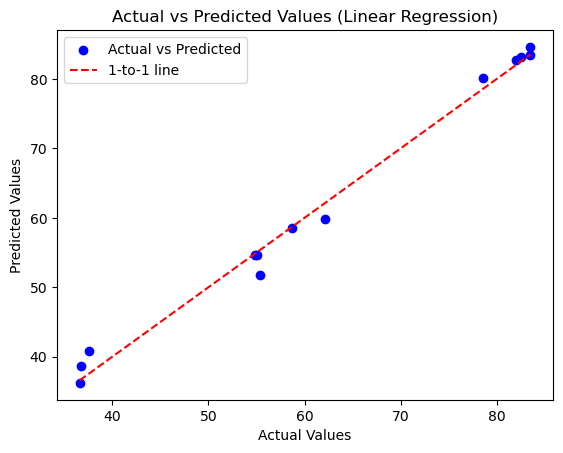

In [163]:
import numpy as np
fig, ax = plt.subplots()

ax.scatter(y_test, y_pred, color='blue', label='Actual vs Predicted')

ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='1-to-1 line')

ax.set_xlabel('Actual Values')
ax.set_ylabel('Predicted Values')
ax.set_title('Actual vs Predicted Values (Linear Regression)')
ax.legend()

plt.show()


In [164]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

k = 5

# Initialize KFold
kf = KFold(n_splits=k, shuffle=True, random_state=156)

# Perform k-fold cross-validation
cv_results_linear = cross_val_score(model_linear, X_train, y_train, cv=kf)
cv_results_mean_linear = cv_results_linear.mean()

print(f"{k} fold cross-validation results for Linear regression:", cv_results_linear)
print("Mean accuracy:", cv_results_mean_linear)

5 fold cross-validation results for Linear regression: [0.96908184 0.97650831 0.98427395 0.98879606 0.99382427]
Mean accuracy: 0.982496888010872


### Model using Backwards Stepwise selection

Coefficients:
total_dwelling : 7.229734209882114e-05
labour_participation_rate : -1.3773697033317456
unemployment_rate : 0.990845129361067
rental_avilability_rate : 10.166243267920493
owned_accommodation_costs_change : 0.5140548122762345
CPI : 0.7315663105239267
region_Manitoba : 11.246243330189232
region_Ontario : -12.210065807872816
region_Quebec : 14.039583626704763
region_Saskatchewan : -29.88099543429346

Selected Features: Index(['total_dwelling', 'labour_participation_rate', 'unemployment_rate',
       'rental_avilability_rate', 'owned_accommodation_costs_change', 'CPI',
       'region_Manitoba', 'region_Ontario', 'region_Quebec',
       'region_Saskatchewan'],
      dtype='object')
Mean Squared Error (MSE): 3.807296338926397
Root Mean Squared Error (RMSE): 1.951229442922179
R-squared (R2): 0.9877933258445571


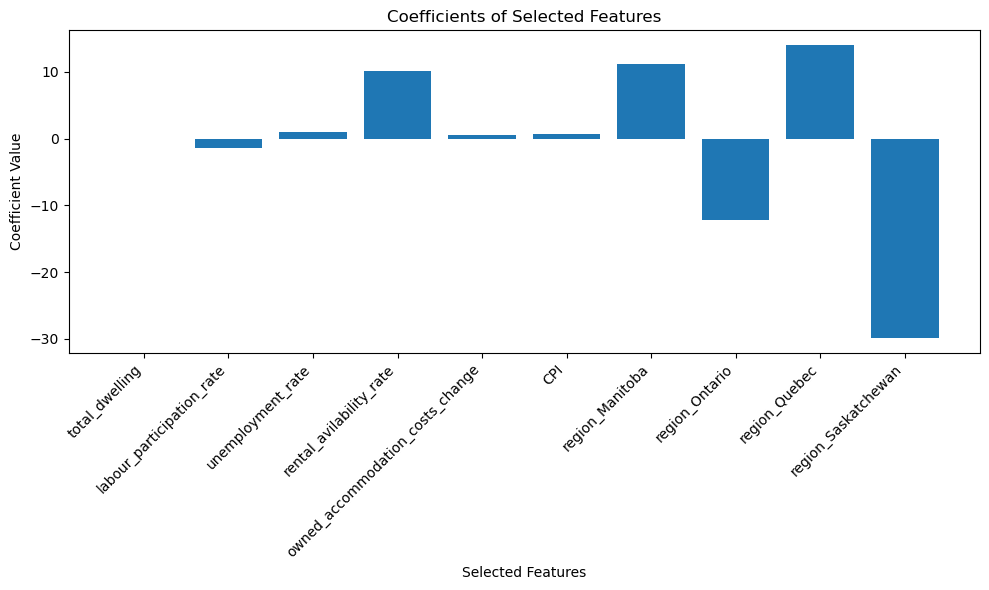

In [165]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt

model = LinearRegression()

selector = SequentialFeatureSelector(model, direction='backward')

selector.fit(X_train, y_train)

selected_features = X_train.columns[selector.get_support()]

model.fit(X_train[selected_features], y_train)

y_pred = model.predict(X_test[selected_features])

mse_linear_filtered = metrics.mean_squared_error(y_test, y_pred)
rmse_linear_filtered = metrics.mean_squared_error(y_test, y_pred, squared=False)
r2_linear_filtered = metrics.r2_score(y_test, y_pred)

print("Coefficients:")
for feature, coef in zip(selected_features, model.coef_):
    print(feature, ":", coef)

print("")
print("Selected Features:", selected_features)
print("Mean Squared Error (MSE):", mse_linear_filtered)
print("Root Mean Squared Error (RMSE):", rmse_linear_filtered)
print("R-squared (R2):", r2_linear_filtered)

# Plotting the coefficients
plt.figure(figsize=(10, 6))
plt.bar(selected_features, model.coef_)
plt.xlabel('Selected Features')
plt.ylabel('Coefficient Value')
plt.title('Coefficients of Selected Features')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [166]:
from sklearn.linear_model import Lasso


model_lasso = Lasso(alpha=0.1)  

model_lasso.fit(X_train, y_train)

y_pred = model_lasso.predict(X_test)

mse_lasso = metrics.mean_squared_error(y_test, y_pred)
rmse_lasso = metrics.mean_squared_error(y_test, y_pred, squared=False)
r2_lasso = metrics.r2_score(y_test, y_pred)

print("Coefficients:")
for feature, coef in zip(X.columns, model_lasso.coef_):
    print(feature, ":", coef)

print("")
print("Mean Squared Error (MSE):", mse_lasso)
print("Root Mean Squared Error (RMSE):", rmse_lasso)
print("R-squared (R2):", r2_lasso)

Coefficients:
population : -0.0011848339642407631
total_dwelling : 0.0005346797647000318
total_dwelling_market : -0.00045045070145315486
labour_participation_rate : -1.5849457123846356
unemployment_rate : 2.012243580245823
disposable_income_change : -0.027890568374740014
rental_vacancy_rate : -0.0
rental_avilability_rate : 5.1192708754883895
owned_accommodation_costs_change : 0.4734285084625628
rental_accommodation_costs_change : 0.0
CPI : 1.11506356062117
year : 0.0
region_Alberta : 0.0
region_Manitoba : 0.0
region_New Brunswick : 0.0
region_Nova Scotia : -9.369397067104318
region_Ontario : 0.0
region_Prince Edward Island : 0.0
region_Quebec : 0.0
region_Saskatchewan : -20.48891209640671

Mean Squared Error (MSE): 4.241555371521016
Root Mean Squared Error (RMSE): 2.059503671159878
R-squared (R2): 0.9864010363986992


In [167]:
cv_results_lasso = cross_val_score(model_lasso, X_train, y_train, cv=kf)
cv_results_mean_lasso = cv_results_lasso.mean()

print(f"{k} fold cross-validation results for Lasso regression:", cv_results_lasso)
print("Mean accuracy:", cv_results_mean_lasso)

5 fold cross-validation results for Lasso regression: [0.98667829 0.98763971 0.98266217 0.96418068 0.99225368]
Mean accuracy: 0.9826829068512024


### Random Forest Method

In [168]:
from sklearn.ensemble import RandomForestRegressor

model_rf = RandomForestRegressor (n_estimators=100, random_state=156, max_features=30)

model_rf.fit(X_train, y_train)
preds_test = model_rf.predict(X_test)

mse_rf = metrics.mean_squared_error(y_test, preds_test)
rmse_rf = metrics.mean_squared_error(y_test, preds_test, squared=False)
r2_rf = metrics.r2_score(y_test, preds_test)

print("")
print("Mean Squared Error (MSE):", mse_rf)
print("Root Mean Squared Error (RMSE):", rmse_rf)
print("R-squared (R2):", r2_rf)


Mean Squared Error (MSE): 62.64707046153829
Root Mean Squared Error (RMSE): 7.914990237614845
R-squared (R2): 0.7991455595146271


In [169]:
#Hyperparameter Tuning

from sklearn.model_selection import GridSearchCV
import numpy as np

clf = RandomForestRegressor(random_state=156)

params = {
    'max_depth': np.arange(5,40,5),
    'n_estimators': np.arange(50,210,50)
}

grid_search = GridSearchCV(estimator=clf, param_grid=params, cv=3, n_jobs=-1, verbose=1, scoring='neg_mean_absolute_error', return_train_score=True)
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 28 candidates, totalling 84 fits


{'max_depth': 10, 'n_estimators': 150}

In [170]:
#Evaluating the tuned model

clf_best = grid_search.best_estimator_
y_test_pred = clf_best.predict(X_test)

MSE_tuned = metrics.mean_squared_error(y_test, y_test_pred)
R2_tuned = metrics.r2_score(y_test, y_test_pred)

print('Hyperparameter tuning of random forest yields MSE and R-squared:', MSE_tuned, R2_tuned)

Hyperparameter tuning of random forest yields MSE and R-squared: 60.51332039548367 0.8059866324091074


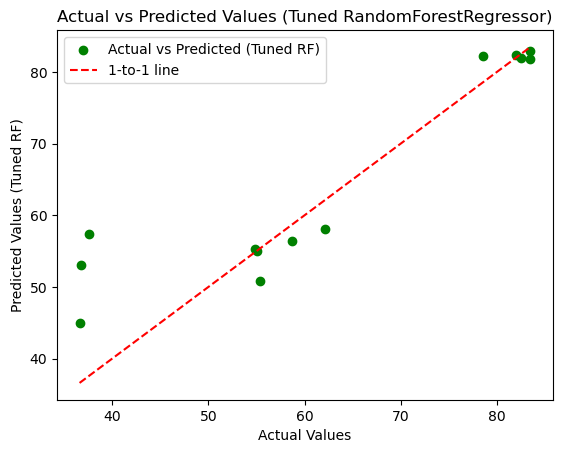

In [171]:
# Create a figure and axis
fig, ax = plt.subplots()

# Plot actual vs predicted values for tuned RandomForestRegressor
ax.scatter(y_test, y_test_pred, color='green', label='Actual vs Predicted (Tuned RF)')

# Plot the 1-to-1 line
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='1-to-1 line')

# Set labels and title
ax.set_xlabel('Actual Values')
ax.set_ylabel('Predicted Values (Tuned RF)')
ax.set_title('Actual vs Predicted Values (Tuned RandomForestRegressor)')
ax.legend()

# Show plot
plt.show()


In [172]:
cv_results_rf = cross_val_score(model_rf, X_train, y_train, cv=kf)
cv_results_mean_rf = cv_results_rf.mean()

print(f"{k} fold cross-validation results for Random Forest regression:", cv_results_rf)
print("Mean accuracy:", cv_results_mean_rf)

5 fold cross-validation results for Random Forest regression: [0.90957087 0.95328769 0.97571351 0.91278163 0.91908016]
Mean accuracy: 0.9340867729959808


### Polynomial Regression

In [173]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score

degree = 2

poly_features = PolynomialFeatures(degree=degree)
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.transform(X_test)

model_poly = LinearRegression()
model_poly.fit(X_train_poly, y_train)

y_pred = model_poly.predict(X_test_poly)

mse_ploy = mean_squared_error(y_test, y_pred)
rmse_ploy = mean_squared_error(y_test, y_pred, squared=False)
r2_ploy = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse_ploy)
print("Root Mean Squared Error:", rmse_ploy)
print("R-squared:", r2_ploy)

Mean Squared Error: 115.81221694358773
Root Mean Squared Error: 10.761608473810396
R-squared: 0.628691367941042


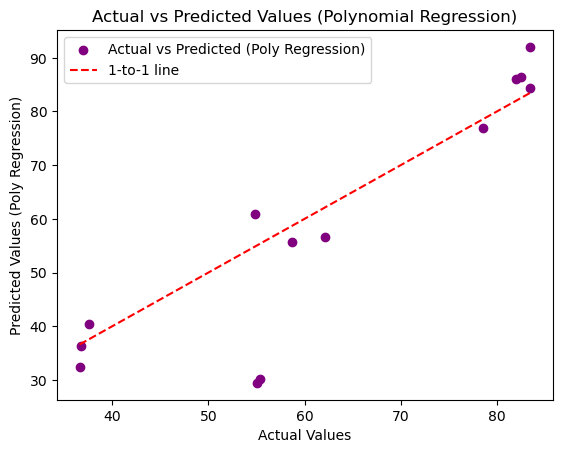

In [174]:
# Plot actual vs predicted values for Polynomial Regression
fig, ax = plt.subplots()

# Plot actual vs predicted values
ax.scatter(y_test, y_pred, color='purple', label='Actual vs Predicted (Poly Regression)')

# Plot the 1-to-1 line
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='1-to-1 line')

# Set labels and title
ax.set_xlabel('Actual Values')
ax.set_ylabel('Predicted Values (Poly Regression)')
ax.set_title('Actual vs Predicted Values (Polynomial Regression)')
ax.legend()

# Show plot
plt.show()


In [175]:
cv_results_poly = cross_val_score(model_poly, X_train, y_train, cv=kf)
cv_results_mean_poly = cv_results_poly.mean()

print(f"{k} fold cross-validation results for Random Forest regression:", cv_results_poly)
print("Mean accuracy:", cv_results_mean_poly)

5 fold cross-validation results for Random Forest regression: [0.96908184 0.97650831 0.98427395 0.98879606 0.99382427]
Mean accuracy: 0.982496888010872


## Model Evaluation

In [176]:
models = ["Linear Regression", "Filtered Linear Regression", "Lasso Regression", "Random Forest Regression", "Polynomial Regression"]

### Mean Squared Error

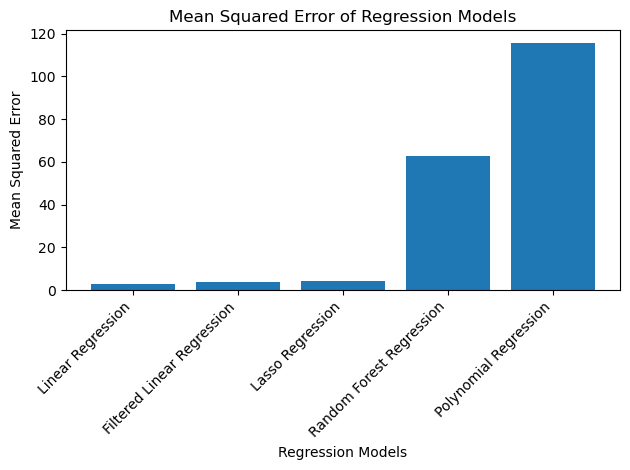

In [177]:
all_mses = [mse_linear, mse_linear_filtered, mse_lasso, mse_rf, mse_ploy]

plt.bar(models, all_mses)
plt.xlabel('Regression Models')
plt.ylabel('Mean Squared Error')
plt.title('Mean Squared Error of Regression Models')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig("mse_plot.png")
plt.show()

### Root Mean Squared Error

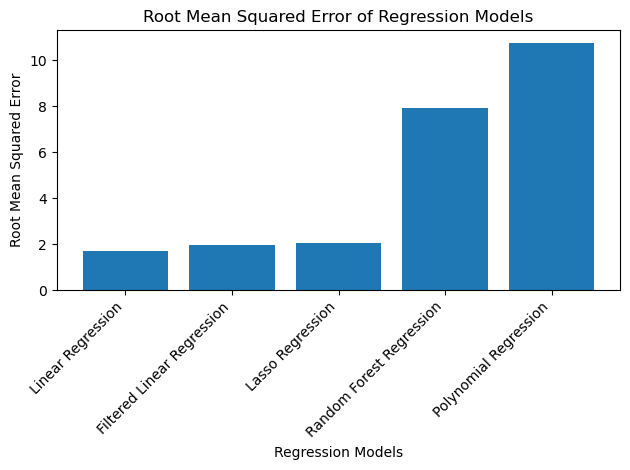

In [178]:
all_rmses = [rmse_linear, rmse_linear_filtered, rmse_lasso, rmse_rf, rmse_ploy]

plt.bar(models, all_rmses)
plt.xlabel('Regression Models')
plt.ylabel('Root Mean Squared Error')
plt.title('Root Mean Squared Error of Regression Models')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig("rmse_plot.png")
plt.show()

### R Squared

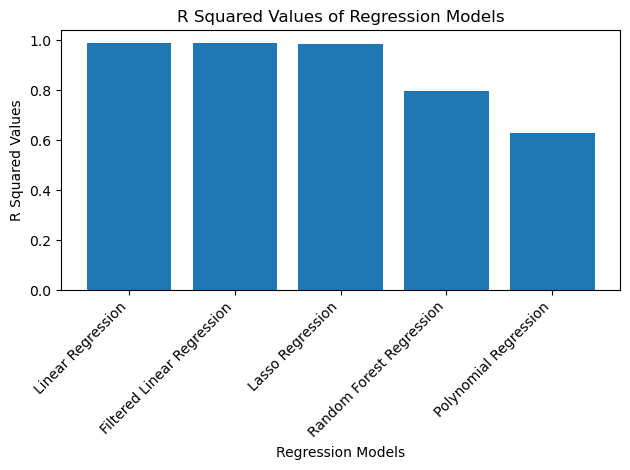

In [179]:
all_r2 = [r2_linear, r2_linear_filtered, r2_lasso, r2_rf, r2_ploy]

plt.bar(models, all_r2)
plt.xlabel('Regression Models')
plt.ylabel('R Squared Values')
plt.title('R Squared Values of Regression Models')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig("r2_plot.png")
plt.show()

### Cross Validation Scores

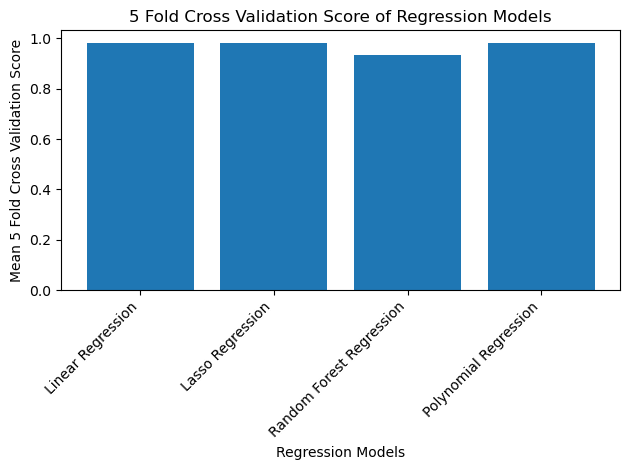

In [180]:
all_cv_score = [cv_results_mean_linear, cv_results_mean_lasso, cv_results_mean_rf, cv_results_mean_poly]
filtered_models = ["Linear Regression", "Lasso Regression", "Random Forest Regression", "Polynomial Regression"]

plt.bar(filtered_models, all_cv_score)
plt.xlabel('Regression Models')
plt.ylabel(f"Mean {k} Fold Cross Validation Score")
plt.title(f"{k} Fold Cross Validation Score of Regression Models")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig("cv_scores_plot.png")
plt.show()